In [ ]:
#extract the tags from the excel file that Sean provided
#save the tags to a text file


import pandas as pd

# load the excel file
excel_file = "data/Tags.csv"
df = pd.read_csv(excel_file)

# extract the tagname column
tags = df['tagname'].dropna().unique()

# save tags to a text file
with open("data/tags_list.txt", "w") as f:
    for tag in tags:
        f.write(f"{tag}\n")

print(f"Successfully extracted {len(tags)} tags and saved to tags_list.txt")


In [ ]:
from transformers import RobertaTokenizer, RobertaModel
from sklearn.cluster import AgglomerativeClustering
import torch
import numpy as np

# Load CodeBERT tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")

# Read tags from the text file
with open("data/tags_list.txt", "r") as f:    #change the path 
    tags = [line.strip() for line in f.readlines()]

print(f"Loaded {len(tags)} tags for clustering.")

# Generate embeddings for each tag
def get_embedding(tag):
    inputs = tokenizer(tag, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the [CLS] token representation as the embedding
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

embeddings = np.array([get_embedding(tag) for tag in tags])

# Perform Clustering with Euclidean Distance (tried with cosine similarity but it yielded some weird clusters (the first one had the majority of the tags and the others had just 1 tag per cluster))
n_clusters = 5  # Adjust as needed
cluster_euclidean = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
labels_euclidean = cluster_euclidean.fit_predict(embeddings)

# Step 5: Print Clusters
print("\n===== Clustering =====\n")

for i in range(n_clusters):
    euclidean_tags = [tags[j] for j in range(len(tags)) if labels_euclidean[j] == i]
    print(f"\nCluster {i + 1} ({len(euclidean_tags)} tags):")
    print(", ".join(euclidean_tags[:15]))  # Show first 15 tags

print("\n Clustering completed successfully!")


In [16]:
#writing all clusters in a file for easy access
output_file = "data/clustering_results.txt"

with open(output_file, "w", encoding="utf-8") as f:
    f.write("=====Clustering Results =====\n\n")
    for i in range(n_clusters):
        cluster_tags = [tags[j] for j in range(len(tags)) if labels_euclidean[j] == i]
        f.write(f"Cluster {i + 1} ({len(euclidean_tags)} tags):\n")
        f.write(", ".join(euclidean_tags) + "\n\n") 

print(f"\n Clustering results saved to '{output_file}'")


 Clustering results saved to 'data/clustering_results.txt'


In [ ]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Score= it shows reasonable clustering but maybe not the best ? 
sil_score = silhouette_score(embeddings, labels_euclidean, metric='euclidean')
print(f"Silhouette Score for Euclidean Clustering: {sil_score:.4f}")


Silhouette Score for Euclidean Clustering: 0.0317


In [17]:
from sklearn.metrics import davies_bouldin_score

# Calculate Davies-Bouldin Index
db_score = davies_bouldin_score(embeddings, labels_euclidean)
print(f"Davies-Bouldin Index: {db_score:.4f}")


Davies-Bouldin Index: 3.8736


In [ ]:
from transformers import RobertaTokenizer, RobertaModel
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
import torch
import numpy as np

# Load CodeBERT tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")

# Read tags from the text file
with open("data/tags_list.txt", "r") as f:  # Update path as needed
    tags = [line.strip() for line in f.readlines()]

print(f"Loaded {len(tags)} tags for clustering.")

# Generate embeddings for each tag
def get_embedding(tag):
    inputs = tokenizer(tag, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the [CLS] token representation as the embedding
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

# Generate embeddings
embeddings = np.array([get_embedding(tag) for tag in tags])
print(f"Generated embeddings with shape: {embeddings.shape}")

# Normalize embeddings
normalized_embeddings = normalize(embeddings)
print("Normalized embeddings.")

# Apply PCA to reduce dimensions
pca = PCA(n_components=50, random_state=42)
reduced_embeddings = pca.fit_transform(normalized_embeddings)
print(f"Reduced embeddings to shape: {reduced_embeddings.shape}")

# Perform Agglomerative Clustering with Euclidean Distance
n_clusters = 5  # Adjust as needed
cluster_euclidean = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
labels_euclidean = cluster_euclidean.fit_predict(reduced_embeddings)

# Calculate Silhouette Score
sil_score = silhouette_score(reduced_embeddings, labels_euclidean, metric='euclidean')
print(f"Silhouette Score for Euclidean Clustering: {sil_score:.4f}")

# Print Clusters and Prepare Output for Saving
print("\n===== Clustering Results =====\n")
output_lines = ["===== Clustering Results =====\n\n"]

for i in range(n_clusters):
    euclidean_tags = [tags[j] for j in range(len(tags)) if labels_euclidean[j] == i]
    cluster_header = f"\n🚀 Cluster {i + 1} ({len(euclidean_tags)} tags):\n"
    cluster_tags = ", ".join(euclidean_tags[:15]) + "\n\n"  # Show first 15 tags

    # Print to console
    print(cluster_header)
    print(cluster_tags)

    # Append to output file
    output_lines.append(cluster_header)
    output_lines.append(", ".join(euclidean_tags) + "\n\n")  # Save all tags in file

print("Clustering completed successfully!")

# Save Clustering Results to a Text File
output_file = "data/clustering_results.txt"
with open(output_file, "w", encoding="utf-8") as f:
    f.writelines(output_lines)

print(f"Clustering results saved to '{output_file}'")


Clusters: 2, Silhouette Score: 0.1441
Clusters: 3, Silhouette Score: 0.0921
Clusters: 4, Silhouette Score: 0.0948
Clusters: 5, Silhouette Score: 0.0978
Clusters: 6, Silhouette Score: 0.0436
Clusters: 7, Silhouette Score: 0.0426
Clusters: 8, Silhouette Score: 0.0336
Clusters: 9, Silhouette Score: 0.0251
Clusters: 10, Silhouette Score: 0.0268


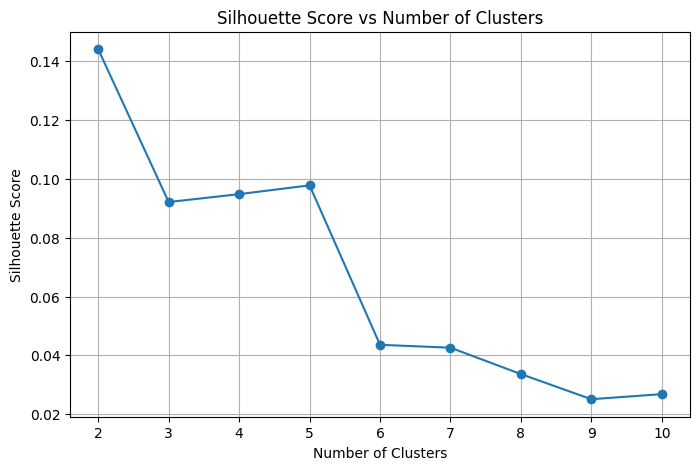

In [ ]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Range of clusters to try= cluster 5 seems to be the best one 
range_n_clusters = list(range(2, 11))
silhouette_scores = []

# Run clustering for different n_clusters and compute Silhouette Scores
for n_clusters in range_n_clusters:
    cluster = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    labels = cluster.fit_predict(reduced_embeddings)  # Use reduced embeddings if PCA applied
    score = silhouette_score(reduced_embeddings, labels, metric='euclidean')
    silhouette_scores.append(score)
    print(f"Clusters: {n_clusters}, Silhouette Score: {score:.4f}")

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()
